# <center> Santiment Hands On Blockchain Analytics Tutorial </center>
# <center><b> Pumps&Dumps on Centralized Exchanges </center>

Alexander Grablevski @Santiment.net

## Welcome to Santiment Hands On Tutorial!
Next hour we will be speaking about:
- How in Santiment we think about Ethereum data
- What is the difference between Centralized and Decentralized exchanges
- Pumps on centralized Exchanges
- Conclusions and thoughts

## <b> How we think about Ethereum data

<b> Challenges </b>
- Dealing with LARGE amount of data
- Crunching different blockchain types (UTXO and account-based)
- Maintaining real-time systems
- Providing fault-tolerance

Data Engineering starts with quering blockchain fullnode and ends in the database with analyzable data format.

How to export the Data: https://github.com/santiment/eth-exporter

Think about Ethereum data from transactions perspective (<b>transaction</b> = unit of data)

<b>Transfer Transaction:</b>
- Timestamp (datetime or blockNumber)
- Sender
- Receiver
- Sended amount
- Token (ETH, ERC20, etc)
- TransactionHash

## <b> Centralized and Decentralized Exchanges

<b>Decentralized Exchanges (DEX):</b>
- is a contract stored onchain and executed by EVM (in a case of Ethereum)
- to bet you need to send the transaction
- every trade is stored in the blockchain
- do not owe users' funds
- 100% transparent
- may have or may not have UI

DEXes:
- IDEX
- Kyber
- Oasis etc..


*may not work with ETH but with WETH or KyberETH

<b>Сentralized Exchanges (CEX):</b>
- is a real-world entity
- owe custodian addresses (hot/cold wallets)
- trades happen on the exchange engine and are not stored in the blockchain
- do owe users' funds
- non transparent
- intercation via UI

CEXes:
- [Binance](https://etherscan.io/address/0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be)
- [Bitfinex](https://etherscan.io/address/0x876eabf441b2ee5b5b0554fd502a8e0600950cfa)
- [Huobi](https://etherscan.io/address/0xd8a83b72377476d0a66683cde20a8aad0b628713)
- [Coinbase](https://etherscan.io/address/0x89135c5ea509a1395287ddcdeb1ec307aed78c15) etc..

<img src="exchanges.png">

<b> Deposit and Withdrawal addresses</b>
https://etherscan.io/address/0xc96d9e6361d344781eae1314b306cfbd73696606

## Setup

### [Sanpy](https://github.com/santiment/sanpy)

In [1]:
# ! pip3 install sanpy

In [2]:
# ! pip3 install fbprophet

In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import san
from san.backtest import Backtest
from fbprophet import Prophet

from utils import fancy_plot, get_san_metric
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
from keys import KEY_ as KEY
san.ApiConfig.api_key = KEY

In [5]:
from_date = '2017-01-01'
to_date = '2019-11-01'
asset = 'ethereum'
interval = '1d'

# create batch object
batch = san.Batch()

# create a request
batch.get(
    f'daily_active_addresses/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval
)
batch.get(
    f'daily_active_deposits/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval
)
batch.get(
    f'prices/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval
)

# execute the request
[daa, dad, price] = batch.execute()

# merge dataframes
data = daa.rename(columns={'value':'activeAddresses'}).join(dad).join(price['priceUsd'])

# take a look
data.head()

,activeAddresses,activeDeposits,priceUsd
datetime,,,
2017-01-01 00:00:00+00:00,13762,4633,8.17257
2017-01-02 00:00:00+00:00,14982,5058,8.37851
2017-01-03 00:00:00+00:00,14535,4753,9.72525
2017-01-04 00:00:00+00:00,17600,5954,11.25160
2017-01-05 00:00:00+00:00,18489,6147,10.25440


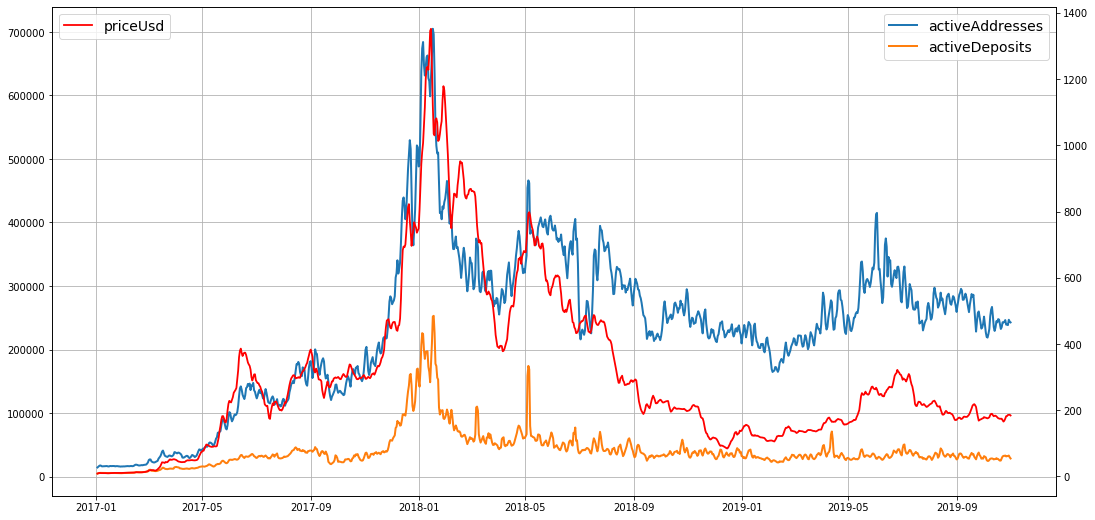

In [6]:
# Historical glimpse
fancy_plot(data.rolling(3).mean(), ['activeAddresses', 'activeDeposits'], 'priceUsd')

## <b> Pumps on Centralized Exchanges

- no way to see what's inside CEX
- but it's possible to observe the activity of CEX' wallets

**Assumption:**
There's an abnormal onchain activity before the pump.

**Metric to observe**: exchange flow balance

In [7]:
from_date = '2018-06-01' # skip bullrun
to_date = '2019-11-01'
asset = 'santiment'

ex_flow = get_san_metric(from_date, to_date, 'exchange_funds_flow', asset, interval='1d', iterate_over_days=700)
price = get_san_metric(from_date, to_date, 'prices', asset, interval='1h', iterate_over_days=120)

data = price.join(ex_flow).fillna(0)
data.head()

,marketcap,priceBtc,priceUsd,volume,inOutDifference
datetime,,,,,
2018-06-01 00:00:00,77922557,0.000166,1.24357,1296560,0.0
2018-06-01 01:00:00,77573539,0.000165,1.23800,1283310,0.0
2018-06-01 02:00:00,78023440,0.000166,1.24518,1303430,0.0
2018-06-01 03:00:00,77776558,0.000166,1.24124,1306730,0.0
2018-06-01 04:00:00,77420021,0.000165,1.23555,1293790,0.0


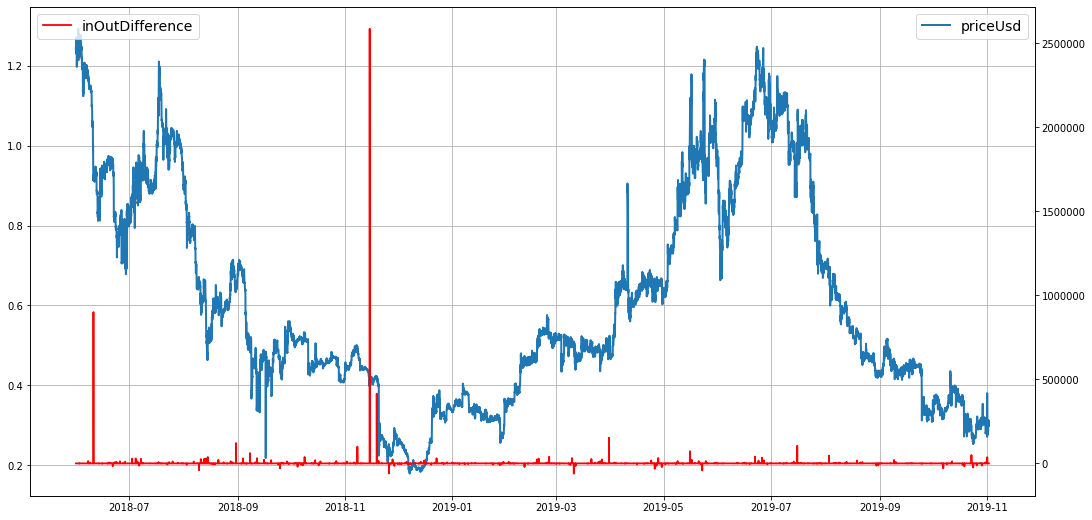

In [8]:
fancy_plot(data, ['priceUsd'], 'inOutDifference')

<b> How to define abnormal activity? </b>
- Statistical way (Granger test, Event study, etc)
- Backtest it!

In order to create backtesting strategy you have to define 2 things:
- when to BUY (1)
- when to SELL (2)

**1)** In order to specify **"entry point"**: create a signal on top of the metric (abnormal exchange flow => buy!)

How to define an "abnormal" behaviour of the metric?
- simple method (>= rolling mean value; outstanding values)
- Facebook approach (actual value is outside the predicted confidence interval)
- [Google approach](https://drive.google.com/file/d/1TyfMYV_hUmHbAKdY6iSnH_LqGkid3Srt/view)


**2)** (tricky one) In order to specify **exit point**:
- naive way (price thresholds)
- signalling (create signals on top of other metrics)
- ML approach (predict tops, haven't try it yet!)
- your ideas? :)

## Detect anomalies: [Prophet](https://github.com/facebook/prophet/tree/master/python)

<img src="prophet.png">

In [9]:
ex_flow_train = get_san_metric(
    start='2018-01-01',
    end='2019-11-01',
    metric='exchange_funds_flow',
    asset='santiment',
    interval='1d', 
    iterate_over_days=700
)

In [10]:
# Transform data to prophet-readable format
ex_flow_train = ex_flow_train.reset_index()
ex_flow_train.columns = ['ds', 'y']

In [11]:
# Create and fit the model
model = Prophet(seasonality_mode='additive')

model.fit(ex_flow_train[ex_flow_train['ds'] < ex_flow.index[0]])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
# Make predictions for the next 30 days

future = model.make_future_dataframe(periods=30)
pred = model.predict(future)

In [13]:
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,4489.423696,-362493.565191,428564.868600,4489.423696,4489.423696,27902.200776,27902.200776,27902.200776,27902.200776,27902.200776,27902.200776,0.0,0.0,0.0,32391.624471
1,2018-01-02,4117.692128,-347399.435297,373106.898690,4117.692128,4117.692128,17443.567669,17443.567669,17443.567669,17443.567669,17443.567669,17443.567669,0.0,0.0,0.0,21561.259797
2,2018-01-03,3745.960560,-383263.120153,404796.839579,3745.960560,3745.960560,17431.783055,17431.783055,17431.783055,17431.783055,17431.783055,17431.783055,0.0,0.0,0.0,21177.743615
3,2018-01-04,3374.228992,-366495.273182,394859.067967,3374.228992,3374.228992,12137.381572,12137.381572,12137.381572,12137.381572,12137.381572,12137.381572,0.0,0.0,0.0,15511.610564
4,2018-01-05,3002.497425,-533630.702525,231932.182854,3002.497425,3002.497425,-148862.659484,-148862.659484,-148862.659484,-148862.659484,-148862.659484,-148862.659484,0.0,0.0,0.0,-145860.162059


In [14]:
# try different confidence intervals
gap = (datetime.datetime.strptime(to_date, '%Y-%m-%d') - datetime.datetime.strptime(from_date, '%Y-%m-%d')).days
predicted = pd.DataFrame(None)

for month in range(gap // 30 + 1):
    model = Prophet(seasonality_mode='additive', interval_width=0.25)
    model.fit(ex_flow_train[ex_flow_train['ds'] < ex_flow.index[month * 30]])
    future = model.make_future_dataframe(periods=30)
    pred = model.predict(future.iloc[-30:])
    predicted = predicted.append(
        pred[['ds', 'yhat_lower', 'yhat_upper']]
    )
    
predicted = predicted.rename(columns={'ds': 'datetime'}).set_index('datetime')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [15]:
data_predicted = data.join(predicted, how='left')

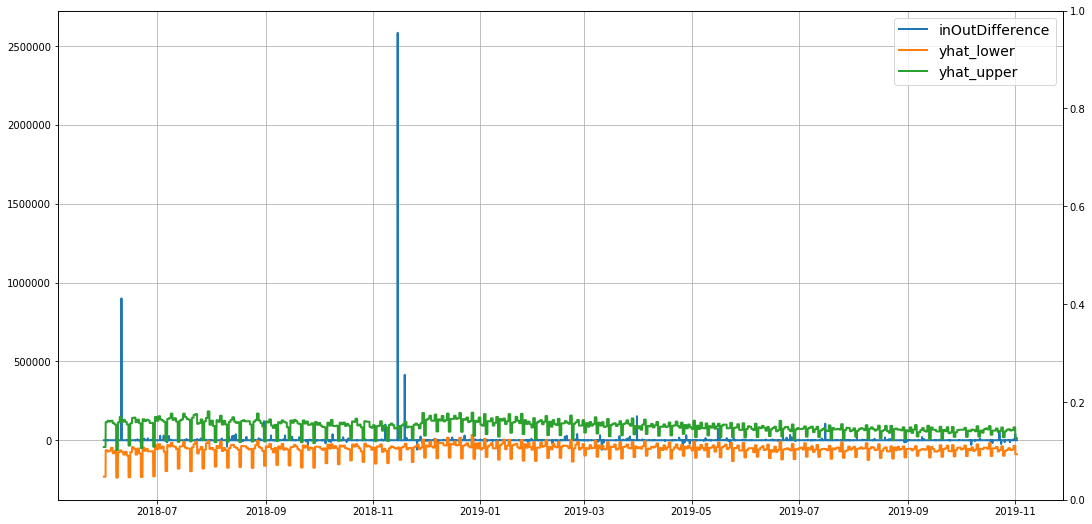

In [16]:
fancy_plot(data_predicted.ffill(), ['inOutDifference', 'yhat_lower', 'yhat_upper'])

### Simple backtest

Lets use **sanpy backtest** tool. 

Sanpy backtest is a super-simple backtest tool that aims to backtest a given strategy on a given asset's price. 

It takes vector of bools for every datepoint. "True" indicates buying or hodling asset on a given time interval and "False" stands for selling.

In [17]:
# Hourly price returns 
data_predicted["returns"] = data_predicted['priceUsd'].pct_change().fillna(0)
# Created Strategy
data_predicted['signal'] = (data_predicted['inOutDifference'] < data_predicted['yhat_lower']) | (data_predicted['inOutDifference'] > data_predicted['yhat_upper'])

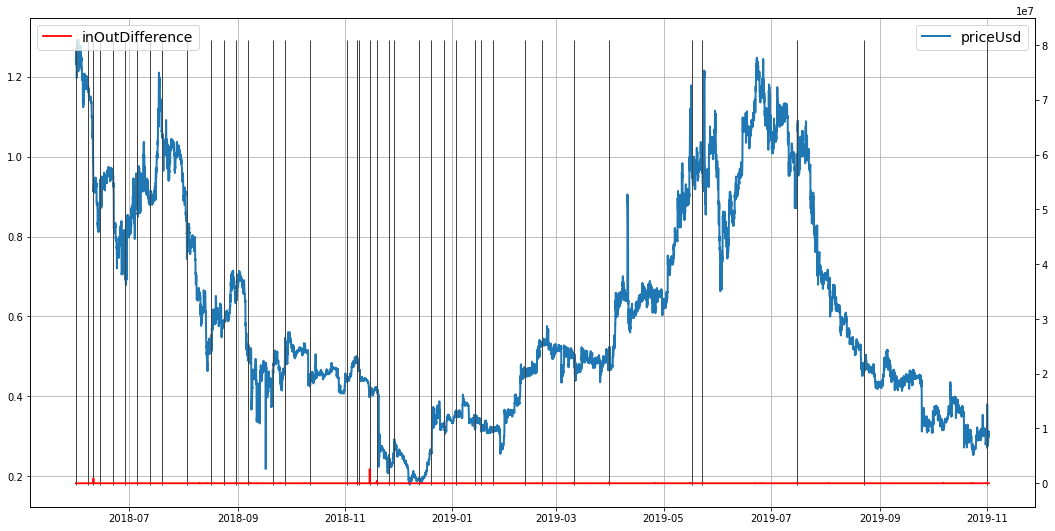

In [18]:
fancy_plot(
    data_predicted,
    ['priceUsd'],
    'inOutDifference',
    signals=data_predicted[data_predicted['signal']==True].index
)

In [19]:
# Create a simple strategy creation function. 
# The idea is to take signals generated from the metric and 
# create the "hodling vector" from it. 
# Relies on simple stop-loss strategy.

def create_strategy(
    df:pd.DataFrame,
    price_name:str,
    signal_name:str,
    gain_to_exit:float,
    loose_to_exit:float,
    max_intervals_to_hodl=np.inf
):

    strategy = df[signal_name].copy()
    state = {'price':None, 'hodl_days': None}

    for t in range(len(strategy)):

        if strategy[t] and not state['price']:  # if signal and asset is not already bought
            # buy asset
            state['price'] = df[price_name][t]
            state['hodl_intervals'] = 0

        elif state['price']:  # if asset is already bought
            if df[price_name][t] > (1 + gain_to_exit) * state['price'] or \
               df[price_name][t] < (1 - loose_to_exit) * state['price'] or \
               state['hodl_intervals'] > max_intervals_to_hodl:  
                # sell asset
                state['price'], state['hodl_intervals'] = None, None
                strategy[t] = False
            else:
                # keep hodling
                strategy[t] = True
                state['hodl_intervals'] += 1

    return strategy

Hodling the asset (benchmark) gives **-75.76%**

A kind of grid-search for finding best params:

Running the code takes ~10min so I've precomputed results.

In [20]:
# %%time

# price_name = 'priceUsd'
# signals_name = 'signal'
# backtest_results = []

# for gain_to_exit in np.arange(0.01, 1.02, 0.05):
#     for loose_to_exit in np.arange(0.01, 1.02, 0.05):
        
#         data_predicted['trades'] = create_strategy(data_predicted, price_name, signals_name, gain_to_exit, loose_to_exit)
#         bt = Backtest(data_predicted.returns.dropna(), data_predicted.trades)

#         backtest_results.append({
#             'gain_to_exit': round(gain_to_exit, 3),
#             'loose_to_exit': round(loose_to_exit, 3),
#             'returns': bt.get_return(decimals=4)
#         })

# backtest_results = pd.DataFrame(backtest_results)

CPU times: user 8min 53s, sys: 18.7 ms, total: 8min 53s
Wall time: 8min 53s


In [21]:
#backtest_results.to_csv('backtest_results_prophet.csv', index=False)
backtest_results = pd.read_csv('backtest_results_prophet.csv')

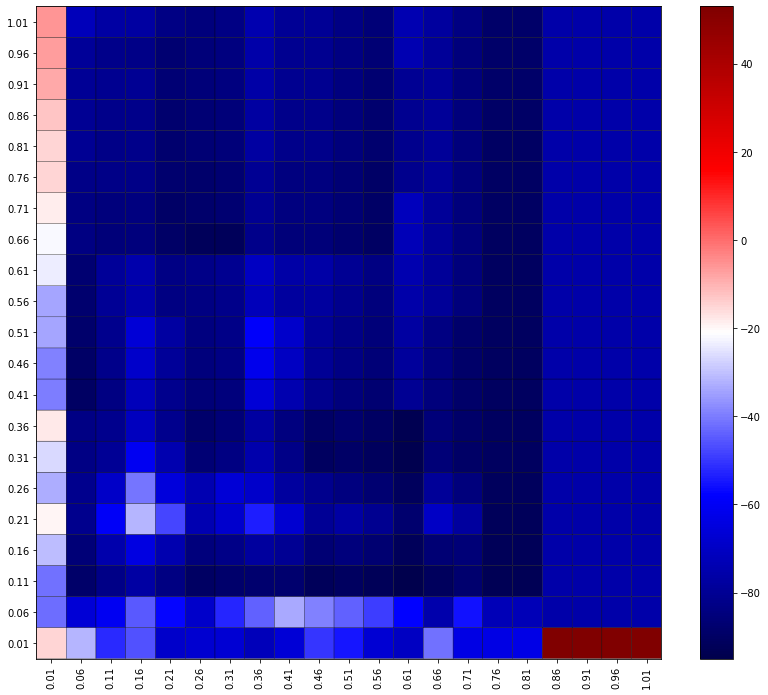

In [22]:
# Create a heatmap of strategy outcomes:

backtest_results_df = backtest_results[['gain_to_exit', 'loose_to_exit', 'returns']]\
    .set_index(['gain_to_exit', 'loose_to_exit'])\
    .unstack('loose_to_exit')
backtest_results_df.columns = backtest_results_df.columns.droplevel()

plt.rcParams['figure.figsize'] = (14.0, 12.0)
plt.pcolor(backtest_results_df, cmap="seismic", edgecolors='k', linewidths=0.3)
plt.yticks(np.arange(0.5, len(backtest_results_df.index), 1), backtest_results_df.index)
plt.xticks(np.arange(0.5, len(backtest_results_df.columns), 1), backtest_results_df.columns, rotation='vertical')
plt.colorbar();

Let's estimate average strategy results Vs benchmark (hodling)

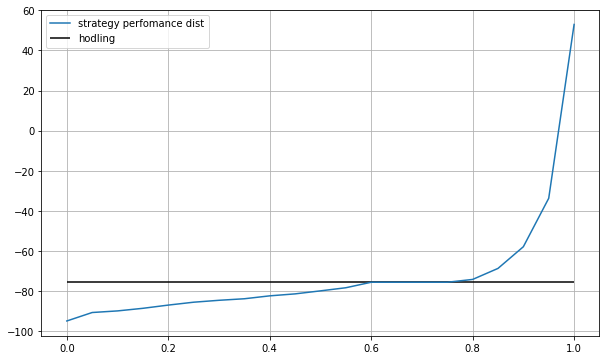

In [23]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(
    [round(i,2) for i in np.arange(0,1.01,0.05)],
    [pd.DataFrame(backtest_results)['returns'].quantile(i) for i in np.arange(0,1.01,0.05)],
    label='strategy perfomance dist'
)
ax1.hlines(bt.get_return_benchmark(), 0, 1, label='hodling')
plt.grid()
plt.legend();

## Detect anomalies: naive way

In [24]:
# Create signals
ex_flow_train['quantile90'] = ex_flow_train['y'].rolling(90, center=False).quantile(0.9)

ex_flow_train['signal'] = ex_flow_train.apply(
    lambda row: True if row['y'] >= row['quantile90'] and row['quantile90'] != np.nan else False,
    axis=1
)

data_simplestr = data.join(ex_flow_train.set_index('ds')[['signal']], how='left')
data_simplestr['signal'] = data_simplestr['signal'].fillna(False)
data_simplestr["returns"] = data_simplestr['priceUsd'].pct_change().fillna(0)

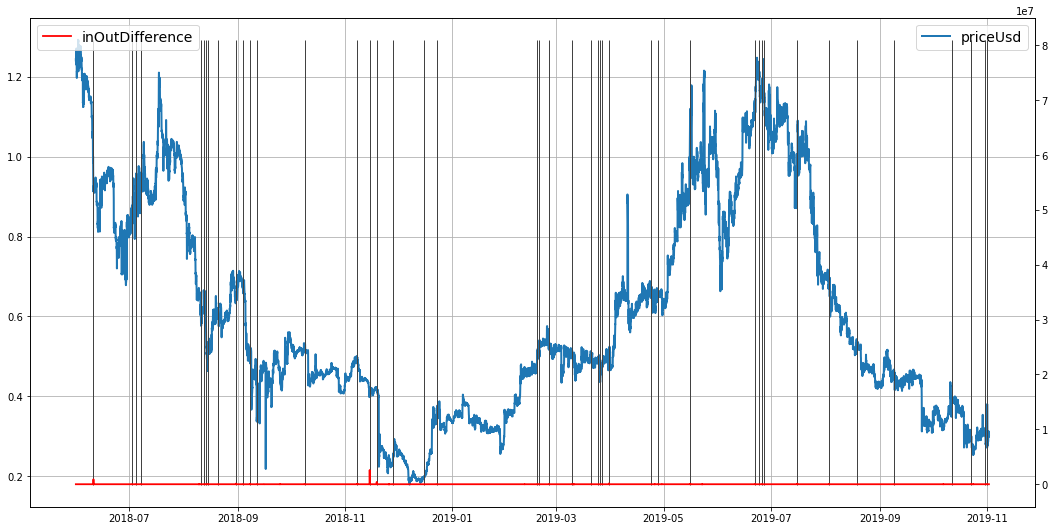

In [25]:
fancy_plot(
    data_simplestr,
    ['priceUsd'],
    'inOutDifference',
    signals=data_simplestr[data_simplestr['signal']==True].index
)

In [26]:
# %%time

# price_name = 'priceUsd'
# signals_name = 'signal'
# backtest_results = []

# for gain_to_exit in np.arange(0.01, 1.02, 0.05):
#     for loose_to_exit in np.arange(0.01, 1.02, 0.05):
        
#         data_simplestr['trades'] = create_strategy(data_simplestr, price_name, signals_name, gain_to_exit, loose_to_exit)
#         bt = Backtest(data_simplestr.returns.dropna(), data_simplestr.trades)

#         backtest_results.append({
#             'gain_to_exit': round(gain_to_exit, 3),
#             'loose_to_exit': round(loose_to_exit, 3),
#             'returns': bt.get_return(decimals=4)
#         })

# backtest_results = pd.DataFrame(backtest_results)

CPU times: user 8min 29s, sys: 19.9 ms, total: 8min 29s
Wall time: 8min 29s


In [27]:
# Again use precomputed outcomes

#backtest_results.to_csv('backtest_results_simplestr90.csv', index=False)
backtest_results = pd.read_csv('backtest_results_simplestr90.csv')

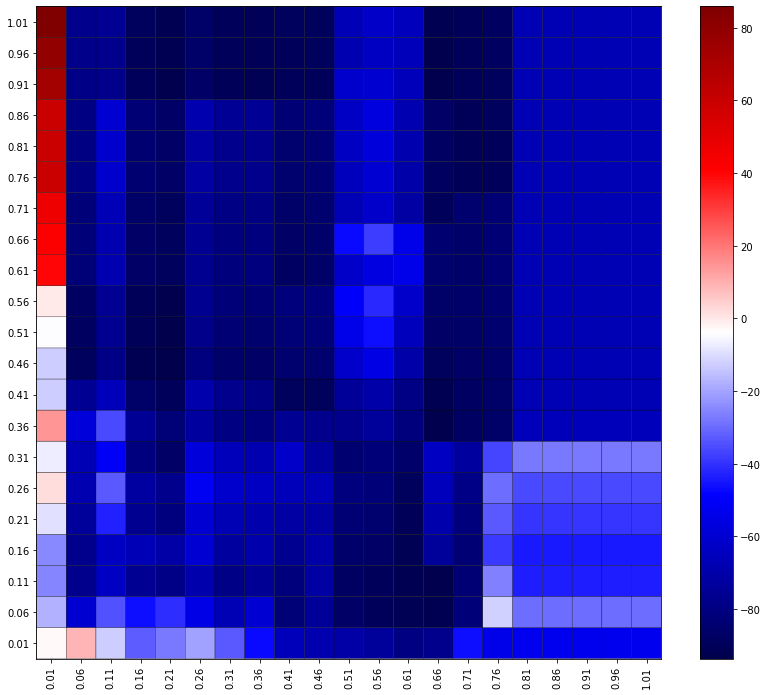

In [28]:
backtest_results_df = backtest_results[['gain_to_exit', 'loose_to_exit', 'returns']]\
    .set_index(['gain_to_exit', 'loose_to_exit'])\
    .unstack('loose_to_exit')
backtest_results_df.columns = backtest_results_df.columns.droplevel()

plt.rcParams['figure.figsize'] = (14.0, 12.0)
plt.pcolor(backtest_results_df, cmap="seismic", edgecolors='k', linewidths=0.3)
plt.yticks(np.arange(0.5, len(backtest_results_df.index), 1), backtest_results_df.index)
plt.xticks(np.arange(0.5, len(backtest_results_df.columns), 1), backtest_results_df.columns, rotation='vertical')
plt.colorbar();

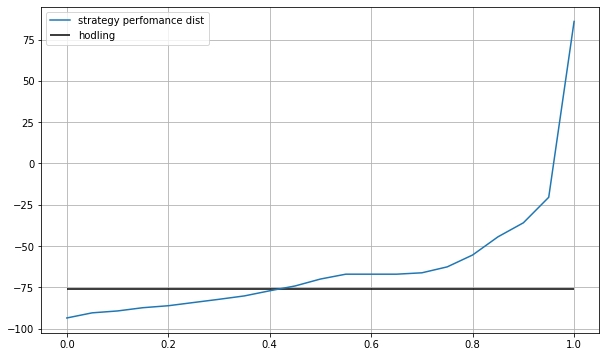

In [29]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(
    [round(i,2) for i in np.arange(0,1.01,0.05)],
    [pd.DataFrame(backtest_results)['returns'].quantile(i) for i in np.arange(0,1.01,0.05)],
    label='strategy perfomance dist'
)
ax1.hlines(bt.get_return_benchmark(), 0, 1, label='hodling')
plt.grid()
plt.legend();

## OHLC pricing data: use hourly highest prices

This section uses hourly highest price data as pricesource. The assumption is that you're able to
spot exit points perfectly. To be more honest to other approaches lets also assume that the asset is bought 
in the worst moment.

In [31]:
# Prepare the data

ohlc = get_san_metric(
    start='2018-06-01',
    end='2019-11-01',
    metric='ohlc',
    asset='santiment',
    interval='1h', 
    iterate_over_days=120
)

high_price = ohlc[['highPriceUsd']]
high_price.ix[high_price[high_price.highPriceUsd == 0].index, 'highPriceUsd'] = 0.187765  # Fix missing point
high_price['returns'] = high_price['highPriceUsd'].pct_change().fillna(0)
high_price = high_price.join(ex_flow_train.set_index('ds')[['y', 'signal']], how='left').fillna(False)

In [32]:
# %%time

# price_name = 'highPriceUsd'
# signals_name = 'signal'
# backtest_results = []

# for gain_to_exit in np.arange(0.01, 1.02, 0.05):
#     for loose_to_exit in np.arange(0.01, 1.02, 0.05):
        
#         high_price['trades'] = create_strategy(high_price, price_name, signals_name, gain_to_exit, loose_to_exit)
#         bt = Backtest(high_price.returns.dropna(), high_price.trades)

#         backtest_results.append({
#             'gain_to_exit': round(gain_to_exit, 3),
#             'loose_to_exit': round(loose_to_exit, 3),
#             'returns': bt.get_return(decimals=4)
#         })

# backtest_results = pd.DataFrame(backtest_results)

CPU times: user 8min 44s, sys: 7.97 ms, total: 8min 44s
Wall time: 8min 44s


In [33]:
# Again use precomputed outcomes

#backtest_results.to_csv('backtest_results_high_price_simplestr.csv', index=False)
backtest_results = pd.read_csv('backtest_results_high_price_simplestr.csv')

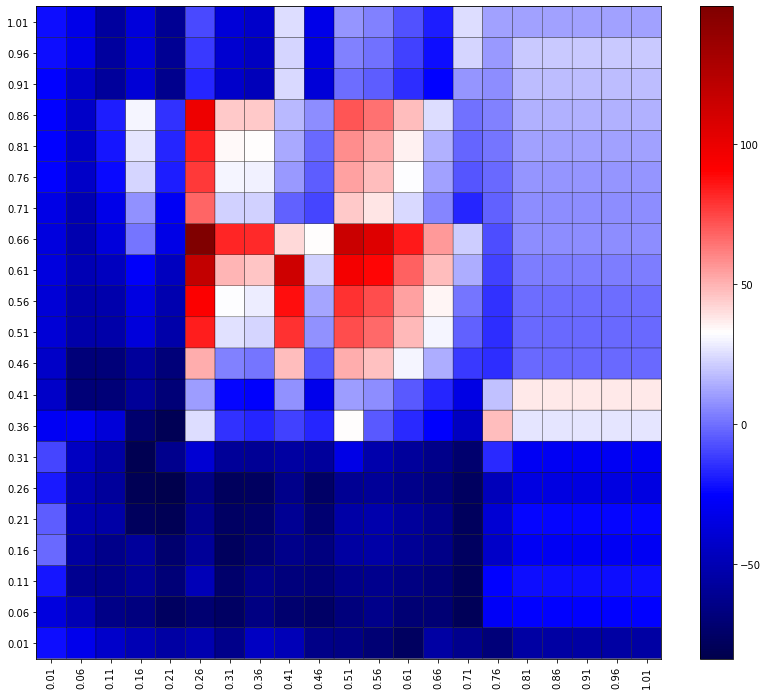

In [34]:
backtest_results_df = backtest_results[['gain_to_exit', 'loose_to_exit', 'returns']]\
    .set_index(['gain_to_exit', 'loose_to_exit'])\
    .unstack('loose_to_exit')
backtest_results_df.columns = backtest_results_df.columns.droplevel()

plt.rcParams['figure.figsize'] = (14.0, 12.0)
plt.pcolor(backtest_results_df, cmap="seismic", edgecolors='k', linewidths=0.3)
plt.yticks(np.arange(0.5, len(backtest_results_df.index), 1), backtest_results_df.index)
plt.xticks(np.arange(0.5, len(backtest_results_df.columns), 1), backtest_results_df.columns, rotation='vertical')
plt.colorbar();

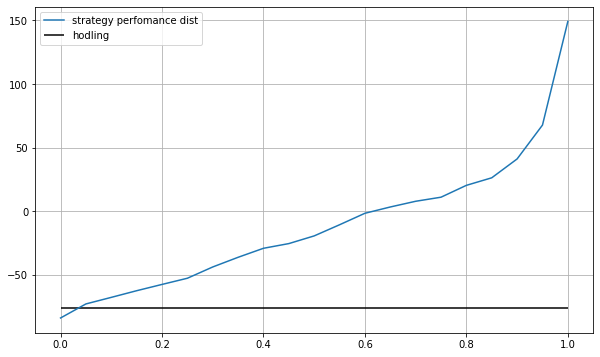

In [35]:
# Overall results

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(
    [round(i,2) for i in np.arange(0,1.01,0.05)],
    [pd.DataFrame(backtest_results)['returns'].quantile(i) for i in np.arange(0,1.01,0.05)],
    label='strategy perfomance dist'
)
ax1.hlines(bt.get_return_benchmark(), 0, 1, label='hodling')
plt.grid()
plt.legend();

In [ ]:
# data_simplestr['trades'] = create_strategy(data_simplestr, 'priceUsd', 'signal', 0.81, 0.01)

# bt = Backtest(data_simplestr.returns.dropna(), data_simplestr.trades)
# bt.summary()
# bt.plot_backtest(viz='hodl')

In [ ]:
# Play yourself :)

# df: high_price  # Strategy with hourly high price and naive signals detection
# df: data_simplestr  # Strategy with hourly average price and naive signals detection
# df: data_predicted  # Strategy with hourly average price and predicted by prophet anomalies

## <b> TLDR and open questions

- Its possible to foresee upcoming pumps using centralized exchanges activity

- Naive way of detecting anomalies works better than prophet predicted anomalies (TODO: experiment with confidence intervals).

- It's important not only to foresee pumps but only to find right "exit" moment. (TODO: experiment with finding tops using other metrics (like soical volume, active addresses, etc)).

- Than more exchange addresses is in the sample the better strategies work. (DISCUSSION: identifying CEX wallets onchain). 

- DISCUSSION: with deposit addresses it's possible to tract different wallets of the user. Any connections between pump-makers?

Questions? Ideas? 
Find me here:
alex.g@santiment.net 
(WhatsApp, Telegram): +375256830154
or join us on **santiment.net** or [our discord channel](https://discord.gg/q3m9vUg)!